In [1]:
# Check if GPU is available
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-04-30 19:23:47.465821: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 19:23:48.440165: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1


2024-04-30 19:23:49.278883: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-30 19:23:49.411994: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-30 19:23:49.412319: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [ ]:
%load_ext tensorboard

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, RandomContrast, RandomFlip, RandomRotation, RandomBrightness, RandomTranslation
from pathlib import Path
import matplotlib.pyplot as plt
import pydot
from tensorboard.plugins.hparams import api as hp
from tensorflow import keras
import keras_tuner as kt

In [3]:
# Main data dir
train_data_dir = Path('train/').with_suffix('')
test_data_dir = Path('test/').with_suffix('')

# Parameters
batch_size = 32
image_size = (150, 150)
num_classes = 15
epochs = 20

In [4]:
plant_labels = [
    "Ulmus carpinifolia",
    "Acer",
    "Salix aurita",
    "Quercus",
    "Alnus incana",
    "Betula pubescens",
    "Salix alba 'Sericea'",
    "Populus tremula",
    "Ulmus glabra",
    "Sorbus aucuparia",
    "Salix sinerea",
    "Populus",
    "Tilia",
    "Sorbus intermedia",
    "Fagus silvatica"
]
plant_labels = sorted(plant_labels)
print(plant_labels)

['Acer', 'Alnus incana', 'Betula pubescens', 'Fagus silvatica', 'Populus', 'Populus tremula', 'Quercus', "Salix alba 'Sericea'", 'Salix aurita', 'Salix sinerea', 'Sorbus aucuparia', 'Sorbus intermedia', 'Tilia', 'Ulmus carpinifolia', 'Ulmus glabra']


In [5]:
# Data loading and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255, # rescale data
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)  # 20% validation split

# Load and preprocess data
train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=42
    )

validation_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=42
    )

test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    seed=42
)

Found 720 images belonging to 15 classes.
Found 180 images belonging to 15 classes.
Found 225 images belonging to 15 classes.


In [6]:
inv_map_train = {v: k for k, v in train_generator.class_indices.items()}
inv_map_test = {v: k for k, v in test_generator.class_indices.items()}

In [7]:
# Augment Data

data_augmentation = tf.keras.Sequential([
  RandomRotation(0.3),
  RandomContrast(0.3)
])

2024-04-30 19:24:09.362498: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-30 19:24:09.362793: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-30 19:24:09.362992: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [8]:

# Model creation
def create_model(hp):
    # Units for dense layer
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)

    model = Sequential()
    model.add(data_augmentation)
    # Number of layers for the CNN
    for i in range(1, hp.Int("num_layers", 2, 6)):
        # Number of filters in Conv2D layers
        model.add(Conv2D(hp.Int(f"filters_{i}", 32, 128, step=32), (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units=hp_units, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Learning rates
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [9]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [15]:
tuner = kt.Hyperband(
                     create_model,
                     objective='val_loss',
                     max_epochs=epochs,
                     factor=3,
                     directory='runs',
                     project_name='leaf_class'
                    )

tuner_bo = kt.BayesianOptimization(
                     create_model,
                     objective='val_loss',
                     directory='runs_bo',
                     project_name='leaf_class'
                    )

tuner_rs = kt.RandomSearch(
                     create_model,
                     objective='val_loss',
                     directory='runs_rs',
                     project_name='leaf_class'
                    )

Reloading Tuner from runs/leaf_class/tuner0.json
Reloading Tuner from runs_bo/leaf_class/tuner0.json
Reloading Tuner from runs_rs/leaf_class/tuner0.json


In [16]:
tuner.search(train_generator, epochs=epochs, validation_data=validation_generator, callbacks=[stop_early])

In [17]:
tuner_rs.search(train_generator, epochs=epochs, validation_data=validation_generator, callbacks=[stop_early])

Trial 5 Complete [00h 02m 10s]
val_loss: 0.8312466740608215

Best val_loss So Far: 0.8312466740608215
Total elapsed time: 00h 19m 07s

Search: Running Trial #6

Value             |Best Value So Far |Hyperparameter
224               |512               |units
3                 |5                 |num_layers
64                |32                |filters_1
0.001             |0.01              |learning_rate
128               |96                |filters_2
32                |32                |filters_3
64                |64                |filters_4
128               |32                |filters_5

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 280ms/step - accuracy: 0.0650 - loss: 6.9533 - val_accuracy: 0.1000 - val_loss: 2.5997
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 268ms/step - accuracy: 0.1697 - loss: 2.4685 - val_accuracy: 0.2944 - val_loss: 2.1008
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 240ms/step - accuracy: 0.3412 - loss: 1.9186 - val_accuracy: 0.3778 - val_loss: 1.7131
Epoch 4/20
23/2

KeyboardInterrupt: 

In [ ]:
tuner_bo.search(train_generator, epochs=epochs, validation_data=validation_generator, callbacks=[stop_early])

In [18]:
best_hps=tuner.get_best_hyperparameters()[0]

print(f"""
The hyperparameter search is complete. The optimal number of layers is {best_hps.get('num_layers')}. The optimal number of units in the densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")



The hyperparameter search is complete. The optimal number of layers is 4. The optimal number of units in the densely-connected
layer is 512 and the optimal learning rate for the optimizer is 0.001.



In [ ]:
best_hps_rs=tuner_rs.get_best_hyperparameters()[0]

print(f"""
The hyperparameter search is complete. The optimal number of layers is {best_hps_rs.get('num_layers')}. The optimal number of units in the densely-connected
layer is {best_hps_rs.get('units')} and the optimal learning rate for the optimizer is {best_hps_rs.get('learning_rate')}.
""")

In [ ]:
best_hps_bo=tuner_bo.get_best_hyperparameters()[0]

print(f"""
The hyperparameter search is complete. The optimal number of layers is {best_hps_bo.get('num_layers')}. The optimal number of units in the densely-connected
layer is {best_hps_bo.get('units')} and the optimal learning rate for the optimizer is {best_hps_bo.get('learning_rate')}.
""")

In [ ]:
model = tuner.hypermodel.build(best_hps)
model.save('hypermodel_1.keras')

In [ ]:
model_rs = tuner_rs.hypermodel.build(best_hps_rs)
model_rs.save('hypermodel_2.keras')

In [ ]:
model_bo = tuner_bo.hypermodel.build(best_hps_bo)
model_bo.save('hypermodel_3.keras')

In [10]:
model = tf.keras.models.load_model('hypermodel_1.keras')
model_rs = tf.keras.models.load_model('hypermodel_2.keras')
model_bo = tf.keras.models.load_model('hypermodel_3.keras')

In [11]:
# Train to find best epoch

history = model.fit(train_generator,epochs=50, validation_data=validation_generator)

Epoch 1/50


/home/lucypher/Desktop/forestry/.venv/lib64/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-04-30 19:24:46.341635: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8901


23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 283ms/step - accuracy: 0.0862 - loss: 2.7262 - val_accuracy: 0.2556 - val_loss: 2.3745
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 198ms/step - accuracy: 0.2915 - loss: 2.1317 - val_accuracy: 0.3722 - val_loss: 1.9542
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step - accuracy: 0.4619 - loss: 1.6420 - val_accuracy: 0.5389 - val_loss: 1.2313
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step - accuracy: 0.5634 - loss: 1.3097 - val_accuracy: 0.6000 - val_loss: 1.1071
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - accuracy: 0.6326 - loss: 1.0984 - val_accuracy: 0.6000 - val_loss: 1.1547
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - accuracy: 0.6107 - loss: 1.1071 - val_accuracy: 0.6333 - val_loss: 1.0054
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - accuracy: 0.6429 - loss: 1.0937 - val_accuracy: 0.6444 - val_loss: 0.9301
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.7162 - loss: 0.8322 - val_accuracy: 0.7278 - val

In [13]:
val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print(f'Best epoch: {best_epoch}')

Best epoch: 25


In [19]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
history = hypermodel.fit(train_generator, epochs=best_epoch, validation_data=validation_generator)


Epoch 1/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step - accuracy: 0.1117 - loss: 2.7539 - val_accuracy: 0.2833 - val_loss: 2.1661
Epoch 2/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 208ms/step - accuracy: 0.3006 - loss: 2.0430 - val_accuracy: 0.4000 - val_loss: 1.6375
Epoch 3/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 208ms/step - accuracy: 0.4649 - loss: 1.4854 - val_accuracy: 0.4444 - val_loss: 1.5728
Epoch 4/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step - accuracy: 0.5740 - loss: 1.2132 - val_accuracy: 0.6000 - val_loss: 1.1983
Epoch 5/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - accuracy: 0.6591 - loss: 1.0755 - val_accuracy: 0.7333 - val_loss: 0.7740
Epoch 6/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - accuracy: 0.6905 - loss: 0.9845 - val_accuracy: 0.7056 - val_loss: 0.8235
Epoch 7/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step - accuracy: 0.7397 - loss: 0.7541 - val_accuracy: 0.5722 - val_loss: 1.2322
Epoch 8/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 207ms/step - accuracy: 0.6956 - loss: 0.9403 - val_accuracy: 0.

In [20]:
hypermodel.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 148, 148, 96)   │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 74, 74, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 72, 72, 64)     │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 34, 34, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9248)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     4,735,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │         7,695 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,459,087 (55.16 MB)

 Trainable params: 4,819,695 (18.39 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,639,392 (36.77 MB)

In [21]:
hypermodel.save('hypermodel_basic.keras')

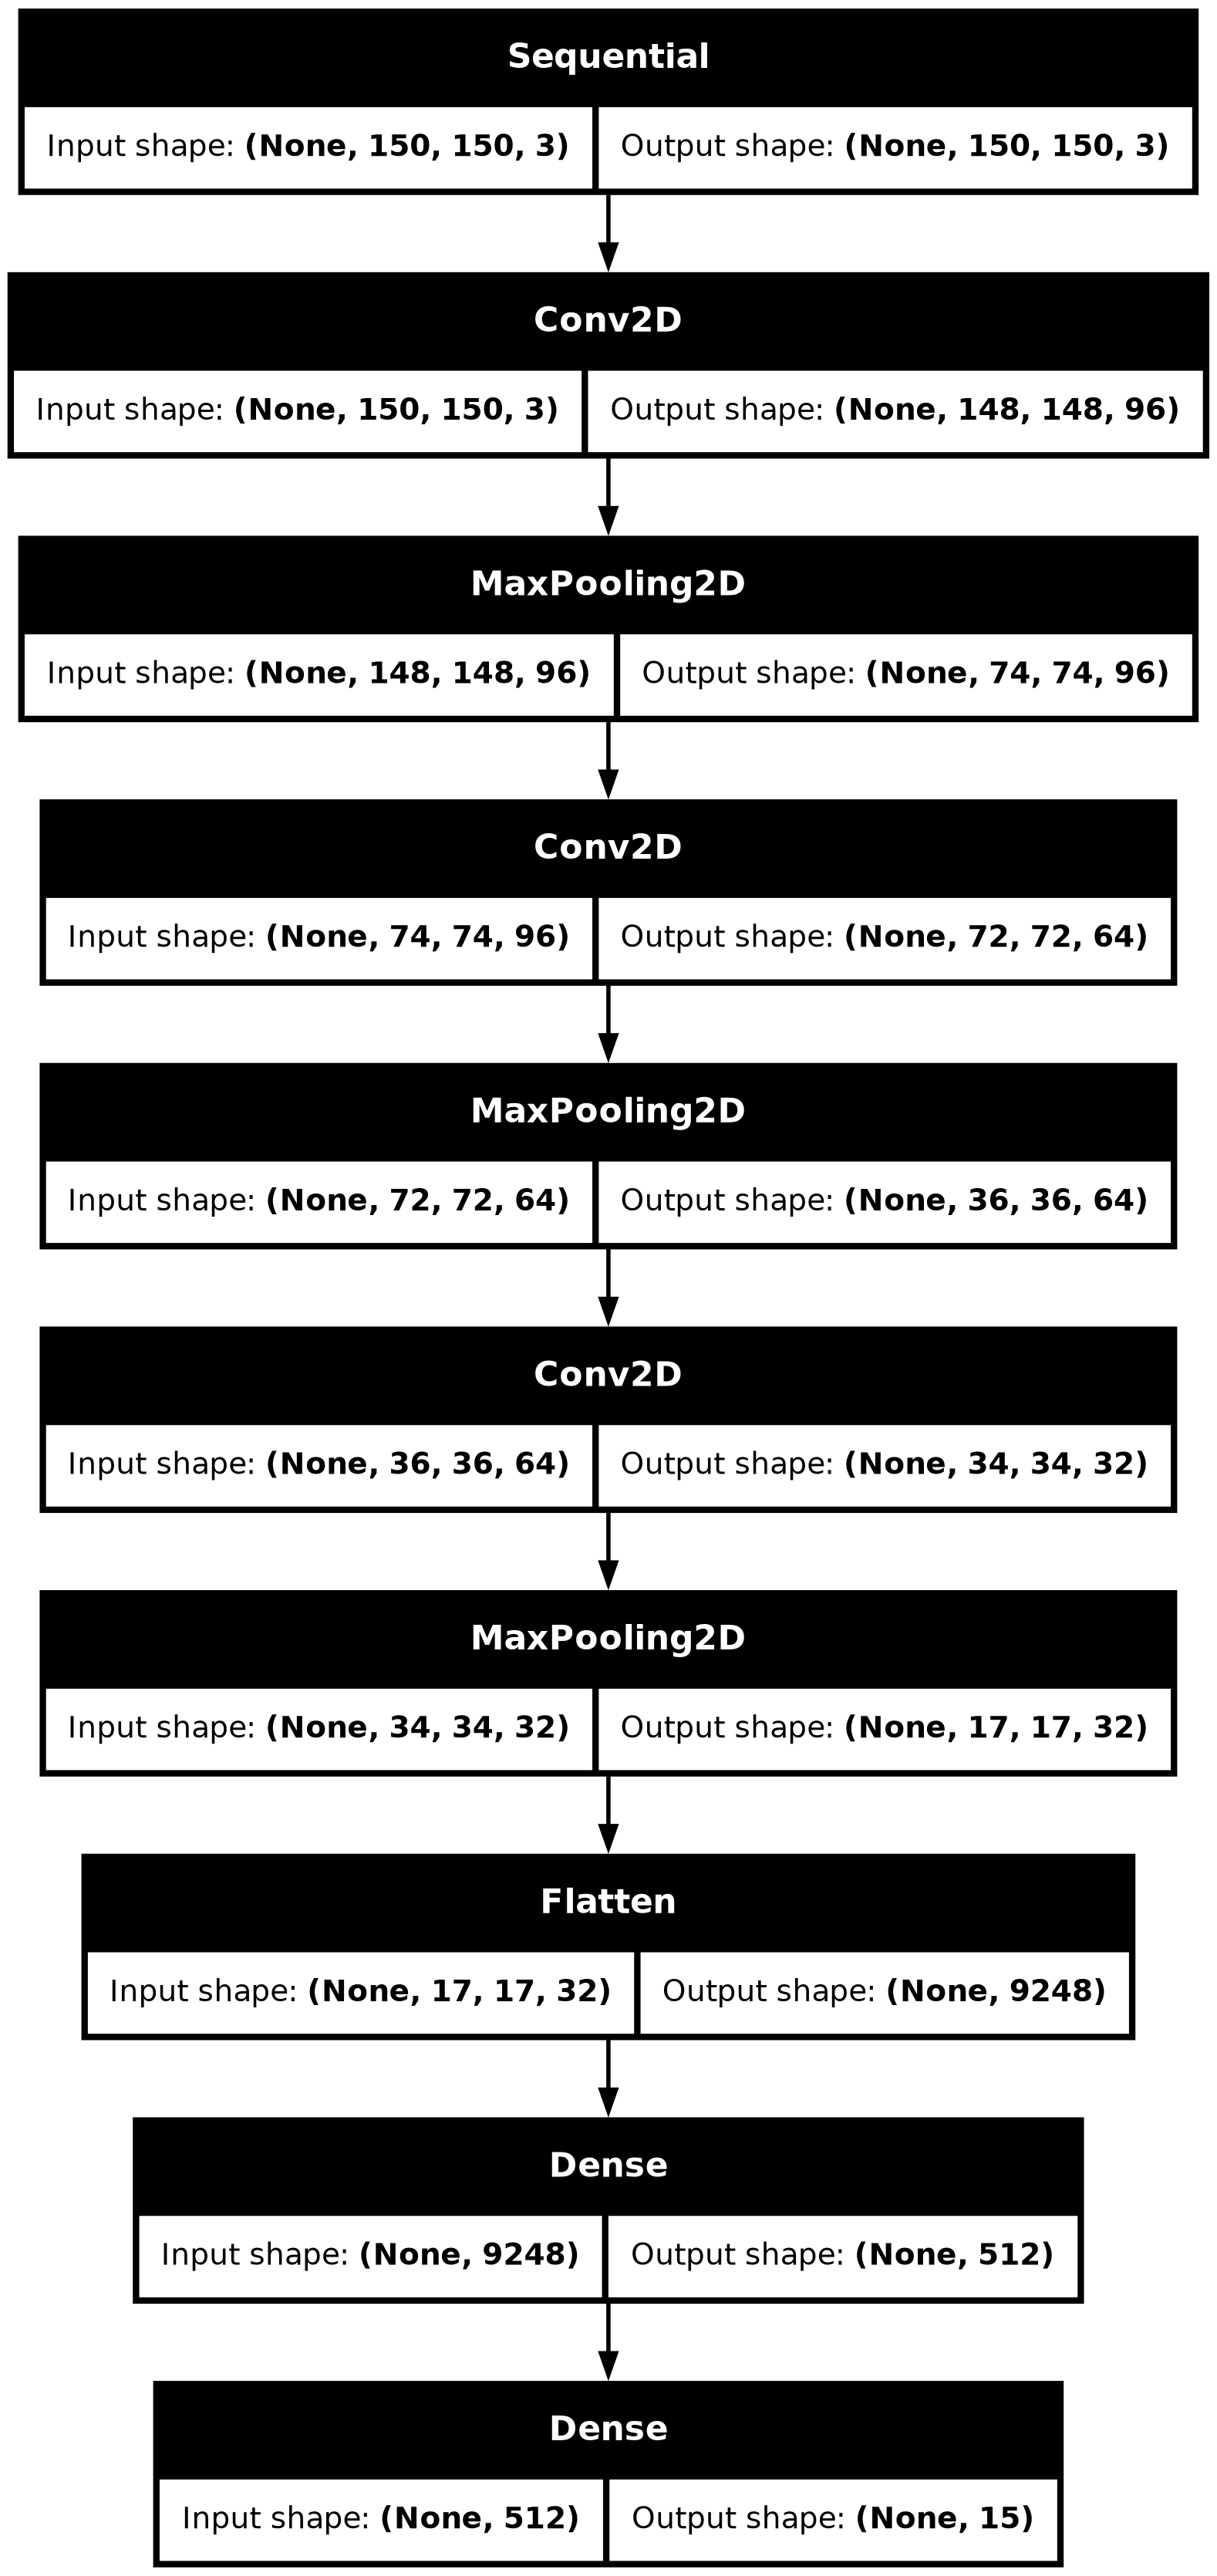

In [22]:
dot_img_file = 'hypermodel.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [23]:
%matplotlib inline

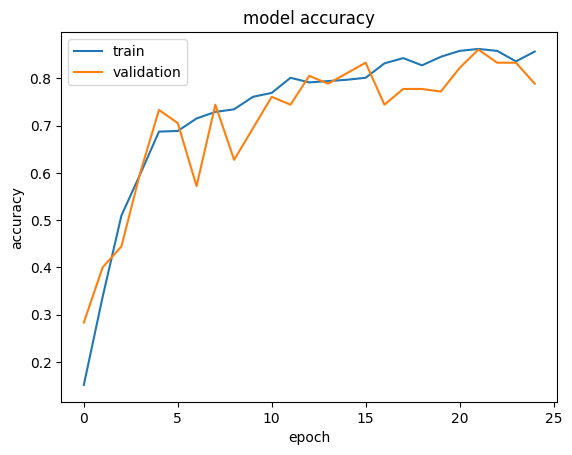

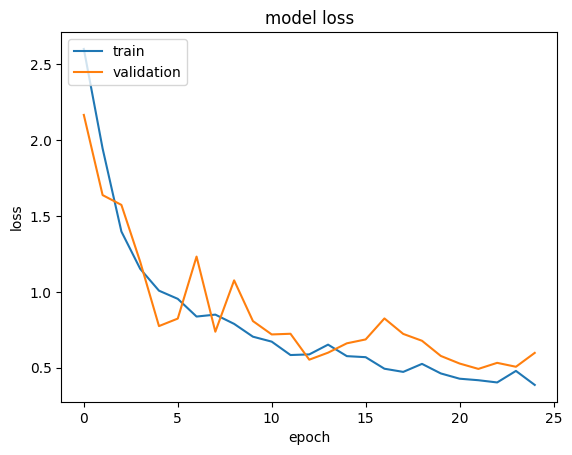

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [25]:
test_history = hypermodel.evaluate(test_generator)

/home/lucypher/Desktop/forestry/.venv/lib64/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 478ms/step - accuracy: 0.8210 - loss: 0.6056


In [26]:
print(test_history)

[0.6076542139053345, 0.8222222328186035]


In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

In [ ]:
def preprocess_image(img_path, target_size=(150,150)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

In [ ]:
test_image = preprocess_image('hahaha.jpg')
model.evaluate(test_generator)


In [ ]:
idx = np.argmax(model.predict(test_image))
inv_map[idx]